In [1]:
import numpy as np
import scipy as sp
import matplotlib as mp
import pickle
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
from itertools import product
%matplotlib inline

In [2]:
sys.path.append('../ligbind/ligbind/')
import ligbind as lb

In [3]:
l_free = lb.dilser()

AttributeError: module 'ligbind' has no attribute 'dilser'

In [4]:
def k1solv(var,parm,rtot,ltot):
    
    k1 = parm
    
    (L,R,RL) = var
    
    eq1 = R + RL - rtot
    eq2 = L + RL - ltot
    eq3 = k1 * R * L - RL
    
    return np.array([eq1,eq2,eq3])
    

In [6]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [7]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [8]:
guessgen(3)

(3.1315884138405474, 0.010577243951583413, 0.12398756692076951)

In [9]:
guesses = [guessgen(3) for i in range(500)]

In [10]:
res = [[optimize.root(k1solv,i,args=(2.0,1.,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in l_free] for i in guesses]

In [11]:
resc = np.array(res)

In [12]:
L = np.array([sp.stats.mode(resc[:,i,0])[0][0] for i in range(18)])
R = np.array([sp.stats.mode(resc[:,i,1])[0][0] for i in range(18)])
RL = np.array([sp.stats.mode(resc[:,i,2])[0][0] for i in range(18)])

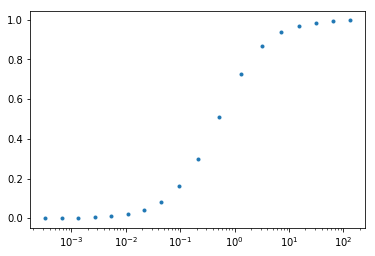

In [13]:
plt.semilogx(L,RL,'.')

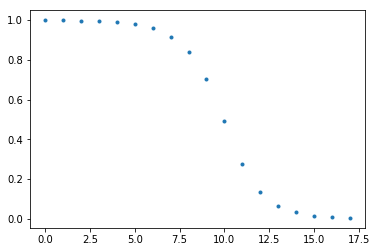

In [14]:
plt.plot(R,'.')

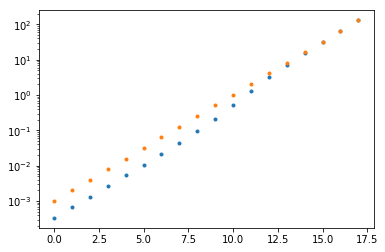

In [15]:
plt.semilogy(L,'.')
plt.semilogy(l_free,'.')

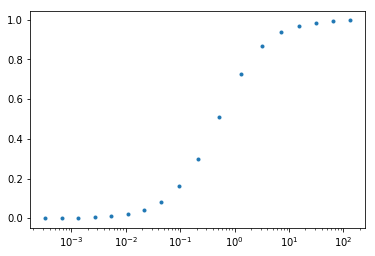

In [16]:
plt.semilogx(L,(RL/(R+RL)),'.')

In [17]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [18]:
guessk2 = (1000.,1000.,1000.,1000.)
parmk2 = np.array([4.,10])

In [19]:
k2guesses = [guessgen(4) for i in range(500)]
resk2 = [[optimize.root(k2solv,i,args=(parmk2,2.,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in l_free] for i in k2guesses]

In [20]:
k2resc = np.array(resk2)

In [21]:
def find_best_root(data,max_lig_index,target_index,lig_max):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    lig_max -- total receptor concentration used for solution
    """
    holder = []
    for i in range(max_lig_index):
        temp = np.around(data[:,i,target_index],decimals=8)
        holder.append(sp.stats.mode(np.extract(((temp > 0)&(temp < lig_max)),temp))[0][0])
    return np.array(holder)

In [22]:
find_best_root(k2resc,18,0,150)

array([  1.10940000e-04,   2.21530000e-04,   4.41680000e-04,
         8.77990000e-04,   1.73543000e-03,   3.39525000e-03,
         6.53061000e-03,   1.22585900e-02,   2.23824000e-02,
         4.00927100e-02,   7.27771200e-02,   1.48031150e-01,
         5.95199440e-01,   4.24340282e+00,   1.24006416e+01,
         2.87750465e+01,   6.15392710e+01,   1.27073579e+02])

In [23]:
dL = find_best_root(k2resc,18,0,150)
dR = find_best_root(k2resc,18,1,150)
dRL = find_best_root(k2resc,18,2,150)
dRLL = find_best_root(k2resc,18,3,150)

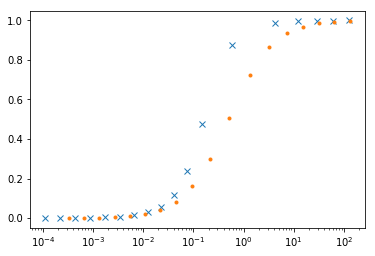

In [24]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')
plt.semilogx(L,(RL/(R+RL)),'.')

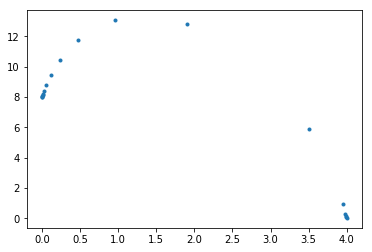

In [27]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

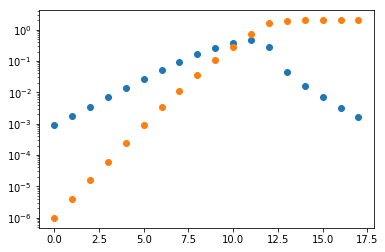

In [28]:
plt.semilogy(dRL,'o')
plt.semilogy(dRLL,'o')

In [29]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = M + 2*MM + ML + 2*MML + 2*MMLL - rtot
    eq2 = L + ML + MML + 2*MMLL - ltot
    eq3 = l20 * M**2 - MM
    eq4 = k11 * L * M - ML
    eq5 = l20 * k21 * M**2 * L - MML
    eq6 = l20 * k21 * k22 * M**2 * L**2 - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])